# Neuron Network Model (GPU)*

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import matplotlib as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import itertools
import matplotlib.pyplot as plt
import time
import datetime
import Model_1Linear_3ELU_1Softmax as model
from sklearn.metrics import roc_curve, auc

# import plot_confusion_matrix as a

In [2]:
Result=[]

acc_train=[1,2,3]
acc_validation=[4,5,6]
acc_test=[7,8,9]

for i in range(3):
    Result.append([acc_train[i],acc_validation[i],acc_test[i]])

In [3]:
result=np.asarray(Result)

In [4]:
np.save("../../Data/Feature_Engineering/testdata.npy",result)

In [5]:
np.load("../../Data/Feature_Engineering/testdata.npy")

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

---
## 0 .Data Preparation*
---

In [6]:
%%time
with open("../../Data/Feature_Engineering/df_features_normalize.p", "rb" ) as f:
    data_features = pickle.load(f)    
with open( "../../Data/Feature_Engineering/df_label.p", "rb" ) as f:
    data_label = pickle.load(f)

CPU times: user 773 ms, sys: 5.1 s, total: 5.87 s
Wall time: 2min 49s


## Feature Selection

In [7]:
%%time
clf=RandomForestClassifier(n_estimators=100,criterion='gini',max_features= 10, 
                           min_samples_leaf=3, bootstrap= False, max_depth= 25, 
                           min_samples_split= 15)

clf.fit(data_features, data_label)

clf.feature_importances_ 
model11 = SelectFromModel(clf, prefit=True)
X_new = model11.transform(data_features)
print(X_new.shape)

(220047, 51)
CPU times: user 36.1 s, sys: 1.29 s, total: 37.4 s
Wall time: 37.6 s


In [8]:
data_features=X_new

**Remember to change Y according to softmax and sigmoid***

here always use softmax 

In [9]:
%%time
print('shape of data_features', data_features.shape)
print('shape of data_label', data_label.shape)
print('---------------------------------------')
X = data_features
Y0 = data_label
Y0 = np.asarray(Y0)
# sigmoid layer:------------------------------
# Y=np.asarray(Y0)
# Y=Y.reshape(Y.shape[0],1)
# softmax Layer:------------------------------
Y1=1-Y0
Y2=Y0
Y1=Y1.reshape(Y1.shape[0],1)
Y2=Y2.reshape(Y2.shape[0],1)
Y=np.concatenate((Y1,Y2),axis=1)

bar_70 = np.floor(X.shape[0]*0.7).astype(int)
bar_70=bar_70+1
bar_80 = np.floor(X.shape[0]*0.8).astype(int)
bar_80=bar_80+1

X_train=X[:bar_70]
print('X_train done.')

Y_train=Y[:bar_70]
Y_train=Y_train.reshape([Y_train.shape[0],Y_train.shape[1]])
print('Y_train done.')

X_validation=X[bar_70:bar_80]
print('X_validation done.')

Y_validation=Y[bar_70:bar_80]
Y_validation=Y_validation.reshape([Y_validation.shape[0],Y_validation.shape[1]])
print('Y_validation done.')

X_test=X[bar_80:]
print('X_test done.')

Y_test=Y[bar_80:]
Y_test=Y_test.reshape([Y_test.shape[0],Y_test.shape[1]])
print('Y_test done.')

print('---------------------------------------')
print('shape of X_train',X_train.shape)
print('shape of Y_train',Y_train.shape)
print('shape of X_validataion',X_validation.shape)
print('shape of Y_validation',Y_validation.shape)
print('shape of X_test',X_test.shape)
print('shape of Y_test',Y_test.shape)

shape of data_features (220047, 51)
shape of data_label (220047,)
---------------------------------------
X_train done.
Y_train done.
X_validation done.
Y_validation done.
X_test done.
Y_test done.
---------------------------------------
shape of X_train (154033, 51)
shape of Y_train (154033, 2)
shape of X_validataion (22005, 51)
shape of Y_validation (22005, 2)
shape of X_test (44009, 51)
shape of Y_test (44009, 2)
CPU times: user 4 ms, sys: 1 ms, total: 5 ms
Wall time: 36.5 ms


In [10]:
(nrTrainSamples, dimX) = X_train.shape
(nrValidationSamples, dimY)  = Y_validation.shape

print ("Finished: data loaded. Stats below: ")
print ("Number of training samples: %d" %nrTrainSamples)
print ("Number of validation  samples: %d" %nrValidationSamples)
print ("Dimension of X_train: %d" %dimX)
print ("Dimension of Y_validation: %d" %dimY)

Finished: data loaded. Stats below: 
Number of training samples: 154033
Number of validation  samples: 22005
Dimension of X_train: 51
Dimension of Y_validation: 2


---
## 1. Parameter Setting
---

In [11]:
sess = tf.InteractiveSession()
BATCH_SIZE    = 100
MAX_ITERS     = 250
LEARNING_RATE = 0.1
require_improvement = 60  # Stop optimization if no improvement found in this many iterations.
n_hidden=256           # 256 units in this hidden lapyer

## Train Model*
**Possible changes on**
- best_validation_accuracy
- PATH

In [12]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def trainModel(accuracy, train_op, x, y, X_train, Y_train, X_validation, Y_validation, X_test, Y_test):
#     Ensure we update the global variables rather than local copies.
#     global best_validation_accuracy
#     global last_improvement

    best_validation_accuracy=0
    Result=[]
    print ("===============================")
    print ("Training started........")

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    for indexIter in range(MAX_ITERS):
        for startIndex, endIndex in zip( range(0,len(X_train),BATCH_SIZE), range(BATCH_SIZE,len(X_train),BATCH_SIZE)):
            # gradient descending, finding parameters.
            sess.run(train_op, feed_dict = {x: X_train[startIndex:endIndex], y: Y_train[startIndex:endIndex]})
            
        # Visualize accuracy only every 10 iterations
        if (indexIter%10==0) or (indexIter == (MAX_ITERS - 1)):
            acc_train = sess.run(accuracy, feed_dict={x:X_train, y:Y_train})
            acc_validation  = sess.run(accuracy, feed_dict={x:X_validation,  y:Y_validation})
            acc_test = sess.run(accuracy, feed_dict={x:X_test,  y:Y_test})
            
            if acc_validation > best_validation_accuracy :
                # Update the best-known validation accuracy.
                best_validation_accuracy = acc_validation
                
                # Set the iteration for the last improvement to current.
                last_improvement = indexIter

                # A string to be printed below, shows improvement found.
                improved_str = '*'
                print('Iteration %d: Accuracy %.5f(training) %.5f(validation) %.5f(test)'%(indexIter+1, acc_train, acc_validation, acc_test)+improved_str)
                Result.append([acc_train,acc_validation,acc_test])
                result=np.asarray(Result)
                np.save("../../Data/Feature_Engineering/testdata01.npy",result)
                
                # Save all variables of the TensorFlow graph to file.
                saver = tf.train.Saver()
                save_dir='../../Data/Propensity_Modeling/Neuron_Net/model_2ELU'
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                saver.save(sess, save_dir)
                print("Model saved in file: %s" % save_dir)
                
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''
                print('Iteration %d: Accuracy %.5f(training) %.5f(validation) %.5f(test)'%(indexIter+1, acc_train, acc_validation, acc_test)+improved_str)
                Result.append([acc_train,acc_validation,acc_test])
                result=np.asarray(Result)
                np.save("../../Data/Feature_Engineering/testdata01.npy",result)

        if (indexIter - last_improvement) > require_improvement:
            print("No improvement found in a while, early stop the training.")
            print ("===============================")
            break
                  
    print ("Training finished.")
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_diff = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(datetime.timedelta(seconds=int(round(time_diff)))))
    print ("===============================")
    

## 2. Main function*
**Possible changes on:**
- cross_entropy

In [13]:
# -------------------------------------------------------------------------------------------------------------------
def main():
    
    #============================
    # 1. Build model (graph)
    #============================
    import tensorflow as tf
    
    x = tf.placeholder(tf.float32, shape=[None, dimX])
    # None is the number of data set, 784 is the dimensions of features
    y = tf.placeholder(tf.float32, shape=[None, dimY])
    
# -------------------------------------------------------------------------------------------------------------------    
    # model returns a score vector over all classes
    [logits,y_pred_prob] = model.Model(x, dimX, dimY, n_hidden)
# -------------------------------------------------------------------------------------------------------------------
    # Get predicted classes
    y_pred = tf.round(y_pred_prob)
    
    # Loss function (Cross-entropy for classification)
    cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits = logits))
    # Error: Only call `sigmoid_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)
    
    # Accuracy(if different measure from loss)
    correct_prediction = tf.equal(y_pred, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #============================
    # 2. Train model
    #============================
    # initialize variables
    tf.global_variables_initializer().run()
    
    # Best validation accuracy seen so far.
    best_validation_accuracy= 0
    # Iteration-number for last improvement to validation accuracy.
    last_improvement = 0

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Train model:
    train_op = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)
    trainModel(accuracy, train_op, x, y, X_train, Y_train, X_validation, Y_validation, X_test, Y_test)

    acc_test = sess.run(accuracy, feed_dict={x:X_test, y:Y_test})
    y_pred_prob=sess.run(y_pred_prob, feed_dict={x:X_test})
    y_pred=sess.run(y_pred, feed_dict={x:X_test})
    print('Final model (may note be the optimal) on test data got accuracy:', acc_test)
    
    return [y_pred_prob, y_pred]

---
## 3. Trained Result:
---

### 3.0 Model 0: 1 Linear + 3 ELu + 1 Softmax

In [14]:
#(REPRODUCIBILITY) set random seeds
tf.set_random_seed(722)

print('Model: 1 Linear + 2 ReLu + 1 Softmax')
[y_pred_prob, y_pred]=main()

Model: 1 Linear + 2 ReLu + 1 Softmax
Training started........
Iteration 1: Accuracy 0.87892(training) 0.88471(validation) 0.87634(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model_2ELU
Iteration 11: Accuracy 0.88670(training) 0.89180(validation) 0.88400(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model_2ELU
Iteration 21: Accuracy 0.89108(training) 0.89798(validation) 0.88802(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model_2ELU
Iteration 31: Accuracy 0.89135(training) 0.89711(validation) 0.88920(test)
Iteration 41: Accuracy 0.89414(training) 0.89902(validation) 0.89207(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model_2ELU
Iteration 51: Accuracy 0.89572(training) 0.90030(validation) 0.89504(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model_2ELU
Iteration 61: Accuracy 0.89626(training) 0.90252(validation) 0.89343(test)*
Model saved in file: ../../Data/Propen

In [15]:
print(y_pred_prob.shape)
print(y_pred.shape)
print(Y_test.shape)

data_accuracy=np.load("../../Data/Feature_Engineering/testdata.npy")

(44009, 2)
(44009, 2)
(44009, 2)


**Confusion matrix**

Confusion Matrix is:
 [[35724  1341]
 [ 3021  3923]]

Plot of Confusion Matrix is:


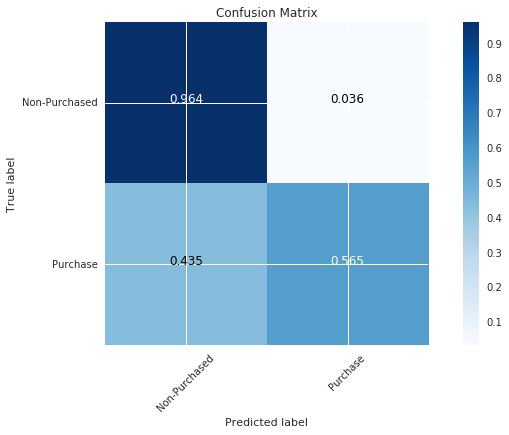

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# cfm = confusion_matrix(y_true, y_pred, labels
cfm = confusion_matrix(Y_test[:,1], y_pred[:,1], labels=[0, 1])
print('Confusion Matrix is:\n',confusion_matrix(Y_test[:,1], y_pred[:,1]))
print('\nPlot of Confusion Matrix is:')
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["Non-Purchased", "Purchase"], normalize=True)
plt.show()

**ROC**

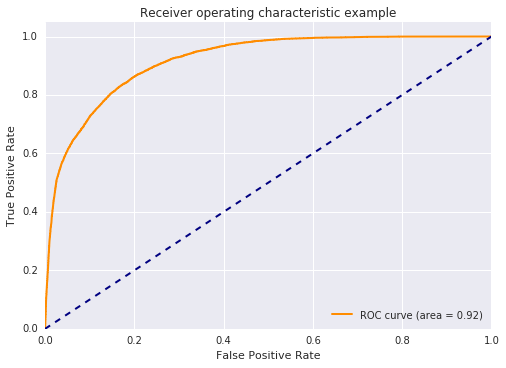

In [17]:
n_classes=1
Y_prob=y_pred_prob

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,1], Y_prob[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test[:,1].ravel(), Y_prob[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


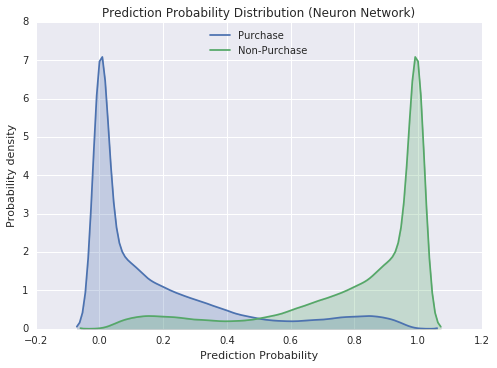

In [34]:
import seaborn as sns
sns.set(color_codes=True)

Y_prob=y_pred_prob


sns.kdeplot(Y_prob[:,1], shade=True, label="Purchase");
sns.kdeplot(Y_prob[:,0], shade=True, label="Non-Purchase");

# sns.kdeplot(Y_prob[:,1], shade=True,cut=0, label="Purchase");
# sns.kdeplot(Y_prob[:,0], shade=True,cut=0,label="Non-Purchase");

plt.xlabel('Prediction Probability')
plt.ylabel('Probability density')
plt.title(r'Prediction Probability Distribution (Neuron Network)')

In [21]:
data_accuracy=np.load("../../Data/Feature_Engineering/testdata.npy")
data_accuracy

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

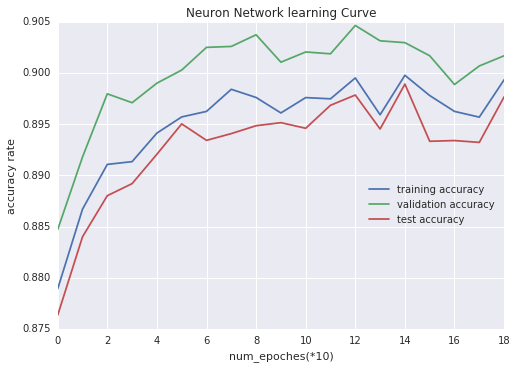

In [52]:
plt.plot(b[:,0] ,label='training accuracy')
plt.plot(b[:,1] ,label='validation accuracy')
plt.plot(b[:,2] ,label='test accuracy')
plt.title('Neuron Network learning Curve')

plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
# plt.legend()#'training accuracy','validation accuracy','test accuracy');
plt.xlabel('num_epoches(*10)');
plt.ylabel('accuracy rate');

In [25]:
a=[[0.87892, 0.88471, 0.87634],
[0.88670, 0.89180, 0.88400],
[0.89108, 0.89798, 0.88802],
[0.89135, 0.89711, 0.88920],
[0.89414, 0.89902, 0.89207],
[0.89572, 0.90030, 0.89504],
[0.89626, 0.90252, 0.89343],
[0.89842, 0.90261, 0.89409],
[0.89762, 0.90375, 0.89486],
[0.89611, 0.90107, 0.89516],
[0.89761, 0.90207, 0.89461],
[0.89749, 0.90189, 0.89686],
[0.89953, 0.90466, 0.89786],
[0.89593, 0.90316, 0.89454],
[0.89979, 0.90298, 0.89893],
[0.89781, 0.90170, 0.89334],
[0.89626, 0.89889, 0.89341],
[0.89570, 0.90070, 0.89323],
[0.89935, 0.90170, 0.89768]]

In [31]:
b=np.asarray(a)

### 3.1 Model: 1 Linear + 1 Sigmoid

In [8]:
#(REPRODUCIBILITY) set random seeds
tf.set_random_seed(722)

print('Model: 1 linear layer + 1 sigmoid layer')
[y_pred_prob, y_pred]=main()

Model: 1 linear layer + 1 sigmoid layer
Training started........
Iteration 1: Accuracy 0.88190(training) 0.88730(validation) 0.87730(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model01
Training finished.
Time usage: 0:02:07
Final model (may note be the optimal) on test data got accuracy: 0.878479


In [9]:
y_pred_prob

array([[ 0.01236884],
       [ 0.00577357],
       [ 0.01659127],
       ..., 
       [ 0.09779712],
       [ 0.11972279],
       [ 0.09042992]], dtype=float32)

In [10]:
y_pred

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

In [ ]:
sum(Y_train==0)/len(Y_train)

### 3.1.1 Model: 1 Linear + 1 Sigmoid (GPU)

In [25]:
#(REPRODUCIBILITY) set random seeds
tf.set_random_seed(722)

print('Model: 1 linear layer + 1 sigmoid layer')
[y_pred_prob, y_pred]=main()

Model: 1 linear layer + 1 sigmoid layer
Training started........
Iteration 1: Accuracy 0.88138(training) 0.88743(validation) 0.87830(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model01
Iteration 11: Accuracy 0.88288(training) 0.88884(validation) 0.87968(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model01
Iteration 21: Accuracy 0.88327(training) 0.88975(validation) 0.87921(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model01
Iteration 31: Accuracy 0.88359(training) 0.89107(validation) 0.87959(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model01
Iteration 41: Accuracy 0.88311(training) 0.88839(validation) 0.87952(test)
Iteration 51: Accuracy 0.88298(training) 0.88921(validation) 0.87959(test)
No improvement found in a while, early stop the training.
Training finished.
Time usage: 0:07:38
Final model (may note be the optimal) on test data got accuracy: 0.879752


In [27]:
y_pred_prob

array([[ 0.03598347],
       [ 0.01091612],
       [ 0.00492952],
       ..., 
       [ 0.05789928],
       [ 0.16166596],
       [ 0.07142878]], dtype=float32)

In [28]:
y_pred_prob[(y_pred_prob>0.8)]

array([ 0.91999072,  0.85221207,  0.80182505, ...,  0.83714122,
        0.85873485,  0.82573932], dtype=float32)

In [33]:
sum(y_pred[(y_pred_prob>0.8)]==0)

344

In [30]:
print(y_pred.shape)
print(y_pred_prob.shape)

(44009, 1)
(44009, 1)


### 3.2 Model: 1 linear + 1 softmax

In [12]:
#(REPRODUCIBILITY) set random seeds
tf.set_random_seed(722)

print('Model: 1 linear layer + 1 softmax layer')
[y_pred_prob, y_pred]=main()

Model: 1 linear layer + 1 softmax layer
Training started........
Iteration 1: Accuracy 0.88255(training) 0.88748(validation) 0.87864(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model01
Iteration 11: Accuracy 0.88337(training) 0.88980(validation) 0.87850(test)*
Model saved in file: ../../Data/Propensity_Modeling/Neuron_Net/model01
Iteration 21: Accuracy 0.88250(training) 0.88975(validation) 0.87952(test)
Iteration 30: Accuracy 0.88344(training) 0.88857(validation) 0.87971(test)
Training finished.
Time usage: 0:03:57
Final model (may note be the optimal) on test data got accuracy: 0.880456


In [13]:
y_pred

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

In [19]:
y_pred[y_pred[:,0]!=1]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

In [25]:
# There're some cases that y_pred_prob has different result to y_pred
sum(y_pred_prob[[y_pred[:,0]!=1]][:,0]>=y_pred_prob[[y_pred[:,0]!=1]][:,1])

678

In [26]:
sum(y_pred_prob[[y_pred[:,0]!=1]][:,0]<=y_pred_prob[[y_pred[:,0]!=1]][:,1])

2407

In [41]:
sum(y_pred[1][:,1]!=1&y_pred[1][:,1]!=1)

2998

In [47]:
y_pred[1].shape

(44009, 2)

In [43]:
y_pred[0].eval()

InvalidArgumentError: Shape [-1,2357] has negative dimensions
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,2357], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-1999953a6897>", line 5, in <module>
    y_pred=main()
  File "<ipython-input-7-65f3510a526d>", line 9, in main
    x = tf.placeholder(tf.float32, shape=[None, dimX])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,2357] has negative dimensions
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,2357], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### 3.2 Confusion Matrix

In [17]:
# Compute confusion matrix
y_Test = tf.argmax(testY, 1)
y_test=y_Test.eval()
cfm = confusion_matrix(y_test, y_pred,labels=range(0,10))
np.set_printoptions(precision=2)

print('\nPlot of Confusion Matrix without nomalize is:')
plt.figure(figsize=(14,10))
plot_confusion_matrix(cfm, classes=range(0,10), normalize=False)
plt.show()
print('\nPlot of Confusion Matrix with nomalize is:')
plt.figure(figsize=(14,10))
plot_confusion_matrix(cfm, classes=range(0,10), normalize=True)
plt.show()

NameError: name 'testY' is not defined

### End
---